# Bayesian Optimization & Supervised Machine Learning

## Overview
1. Load sonar all data
2. Prepared Data
3. Split data into training and testing datasets
4. Encode data for Xgboost (matrix)
5. Train ML models
6. Evaluate ML performance
7. Confusion Matrix
8. Save Model
9. Load Model
10. Predict on new data

In [1]:
# Import Libraries.

from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold

# Metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer

from time import time

# Bayesian Optimization -bayes_opt
#from bayes_opt import BayesianOptimization
#from bayes_opt.util import Colours

# # Bayesian Optimization - skopt
from skopt import BayesSearchCV
from skopt.callbacks import DeadlineStopper, VerboseCallback, DeltaXStopper
from skopt.space import Real, Categorical, Integer

# Catboost
from catboost import CatBoostClassifier, Pool
import ipywidgets # Nødvendig for plot




# Model selection
# Reference: https://www.kaggle.com/shivampanwar/catboost-and-hyperparameter-tuning-using-bayes


# Udeståender:
# Omkode skopt eksempel, så det anvender bayes_opt eller omvendt.
# log-uniform virker ikke med search space.
# Lave RoC-Curve [ok]
# Confusion Matrix [ok]
# Learning Curve []
# Div. andre evaluation methods
# Håndtering af categorial features.

# Deployment
# Save Model
# load model
# Predict "nye data"

# Verbose kun hver 1/10 linje

In [42]:
import sys
import catboost as cb
print('CatBoost version=%s' % cb.__version__)


CatBoost version=0.24.1


### Generate Synthetic binary classification dataset.

In [2]:
##########################
# Load dataset fra min github
from pandas import read_csv
url = 'https://raw.githubusercontent.com/kurtholst/databricks_proj/master/sonar.all-data.csv'
dataset = read_csv(url, header=None)
dataset.head(5)

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R


In [3]:
# Class distribution
dataset[60].value_counts()

M    111
R     97
Name: 60, dtype: int64

In [4]:
# Split-out validation dataset i data og target klasse.
array = dataset.values
data = array[:,0:60].astype(float)
targets = array[:,60]

# For simplificering:
X=data
y=targets

#####################################
# Split i training og test dataset. #
from sklearn.model_selection import train_test_split

train_X, test_X, train_y, test_y = train_test_split(X, y, 
                                                    train_size=0.5,
                                                    test_size=0.5,
                                                    random_state=122)
print("Labels for training and testing data")
print(train_y)
print(test_y)

Labels for training and testing data
['R' 'R' 'R' 'M' 'M' 'M' 'R' 'R' 'M' 'M' 'R' 'R' 'R' 'R' 'M' 'R' 'R' 'M'
 'R' 'M' 'M' 'R' 'M' 'M' 'R' 'R' 'R' 'M' 'M' 'M' 'M' 'R' 'M' 'M' 'R' 'R'
 'R' 'R' 'M' 'M' 'R' 'R' 'M' 'R' 'M' 'R' 'M' 'R' 'M' 'M' 'R' 'R' 'M' 'M'
 'M' 'M' 'R' 'M' 'M' 'M' 'M' 'R' 'R' 'R' 'R' 'M' 'M' 'M' 'M' 'R' 'R' 'M'
 'M' 'R' 'R' 'M' 'R' 'R' 'R' 'M' 'R' 'M' 'R' 'M' 'R' 'R' 'M' 'R' 'R' 'M'
 'R' 'R' 'M' 'M' 'M' 'M' 'R' 'M' 'R' 'R' 'R' 'M' 'M' 'M']
['M' 'R' 'M' 'M' 'M' 'M' 'M' 'R' 'M' 'R' 'M' 'M' 'R' 'R' 'R' 'M' 'R' 'R'
 'M' 'R' 'M' 'R' 'R' 'M' 'R' 'R' 'M' 'M' 'R' 'R' 'R' 'R' 'M' 'M' 'R' 'M'
 'M' 'M' 'M' 'R' 'R' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'R' 'R' 'R' 'R' 'R'
 'M' 'R' 'M' 'R' 'M' 'R' 'R' 'M' 'M' 'M' 'M' 'R' 'M' 'R' 'R' 'R' 'M' 'M'
 'R' 'R' 'M' 'M' 'M' 'R' 'M' 'M' 'R' 'R' 'M' 'M' 'M' 'M' 'M' 'M' 'R' 'M'
 'R' 'M' 'R' 'R' 'M' 'M' 'M' 'M' 'R' 'M' 'R' 'R' 'M' 'M']


#### Confusion Matrix
#### ROC-Curve
#### Save og Load model
#### Predict på "nye data"

# Catboost

# Bayesian Optimization using skopt

In [69]:
# Define clf classifier
clf = CatBoostClassifier(thread_count=2,
                         loss_function='Logloss',
                         task_type="GPU", devices='0:1', #task_type="CPU", device måske ikke nødvendig, ved kun 1 GPU device
                         od_type = 'Iter',
                         metric_period = 10, # Vis kun hver 10 evaluering
                         verbose= True)

In [70]:
# Prepare Search Space for hyperparameter tuning

In [71]:
# Defining Catboost search space - bruges sammen med 
# Fix log-uniform
search_spaces = {'iterations': (10, 100),
                 #'iterations': (10, 1000),
                 'depth': (1, 8),
                 #'learning_rate': (0.01, 1.0, 'log-uniform'),
                 'learning_rate': (0.01, 1.0),
                 #'random_strength': (1e-9, 10, 'log-uniform'),
                 'random_strength': (1e-9, 10),
                 'bagging_temperature': (0.0, 1.0),
                 'border_count': (1, 255),
                 'l2_leaf_reg': (2, 30),
                 #'scale_pos_weight':(0.01, 1.0, 'uniform')}
                 'scale_pos_weight':(0.01, 1.0)}

In [72]:
# Functions for Bayes Search

In [73]:
# Reporting util for different optimizers
def report_perf(optimizer, X, y, title, callbacks=None):
    """
    A wrapper for measuring time and performances of different optmizers
    
    optimizer = a sklearn or a skopt optimizer
    X = the training set 
    y = our target
    title = a string label for the experiment
    """
    import pandas as pd
    import pprint
    start = time()
    if callbacks:
        optimizer.fit(X, y, callback=callbacks)
    else:
        optimizer.fit(X, y)
    d=pd.DataFrame(optimizer.cv_results_)
    best_score = optimizer.best_score_
    best_score_std = d.iloc[optimizer.best_index_].std_test_score
    best_params = optimizer.best_params_
    print((title + " took %.2f seconds,  candidates checked: %d, best CV score: %.3f "
           +u"\u00B1"+" %.3f") % (time() - start, 
                                  len(optimizer.cv_results_['params']),
                                  best_score,
                                  best_score_std))    
    print('Best parameters:')
    pprint.pprint(best_params)
    print()
    return best_params

# RoC-Curver or Area Under Curve:
roc_auc = make_scorer(roc_auc_score, greater_is_better=True, needs_threshold=True)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

In [74]:
# Setting up BayesSearchCV
opt = BayesSearchCV(estimator=clf, 
                    search_spaces=search_spaces,
                    scoring=roc_auc,
                    cv=skf,
                    n_iter=10,
                    n_jobs=1,  # use just 1 job with CatBoost in order to avoid segmentation fault
                    return_train_score=False,
                    refit=True,
                    optimizer_kwargs={'base_estimator': 'GP'},
                    random_state=42)

In [75]:
# Execute bayesian 
best_params = report_perf(optimizer = opt, 
                          X = X, 
                          y = y, 
                          title = 'CatBoost', 
                          callbacks=[VerboseCallback(100), DeadlineStopper(60*10)])

# CPU tid: 188 sec
# GPU 38 sec.

Iteration No: 1 started. Searching for the next optimal point.
0:	learn: 0.5873997	total: 24.9ms	remaining: 920ms
10:	learn: 0.2265690	total: 221ms	remaining: 543ms
20:	learn: 0.1238478	total: 406ms	remaining: 328ms
30:	learn: 0.0814390	total: 594ms	remaining: 134ms
37:	learn: 0.0665968	total: 723ms	remaining: 0us
0:	learn: 0.6077660	total: 18ms	remaining: 666ms
10:	learn: 0.2450429	total: 216ms	remaining: 531ms
20:	learn: 0.1338277	total: 401ms	remaining: 324ms
30:	learn: 0.0905248	total: 605ms	remaining: 137ms
37:	learn: 0.0736800	total: 723ms	remaining: 0us
0:	learn: 0.5997502	total: 19ms	remaining: 705ms
10:	learn: 0.2071213	total: 214ms	remaining: 525ms
20:	learn: 0.1224316	total: 407ms	remaining: 329ms
30:	learn: 0.0793573	total: 634ms	remaining: 143ms
37:	learn: 0.0641598	total: 761ms	remaining: 0us
0:	learn: 0.6045535	total: 21ms	remaining: 776ms
10:	learn: 0.2231224	total: 193ms	remaining: 473ms
20:	learn: 0.1273940	total: 413ms	remaining: 334ms
30:	learn: 0.0853170	total: 605

In [76]:
# Convert ordered dictionary to dictionary
import json
best_params_bayesian = json.loads(json.dumps(best_params))
print(best_params_bayesian)

{'bagging_temperature': 0.8123959883573634, 'border_count': 45, 'depth': 5, 'iterations': 82, 'l2_leaf_reg': 17, 'learning_rate': 0.10450048882284352, 'random_strength': 7.558005328603015, 'scale_pos_weight': 0.8739040497768427}


In [77]:
%%time
tuned_model = CatBoostClassifier(**best_params_bayesian, # **best_params, 
                                 task_type = "CPU", 
                                 od_type='Iter', 
                                 one_hot_max_size=10)
tuned_model.fit(X = train_X, 
                y = train_y)

0:	learn: 0.6695340	total: 2.1ms	remaining: 170ms
1:	learn: 0.6566587	total: 4.06ms	remaining: 162ms
2:	learn: 0.6367517	total: 5.85ms	remaining: 154ms
3:	learn: 0.6202842	total: 7.37ms	remaining: 144ms
4:	learn: 0.6108652	total: 8.88ms	remaining: 137ms
5:	learn: 0.6025533	total: 10.4ms	remaining: 132ms
6:	learn: 0.5761262	total: 13ms	remaining: 139ms
7:	learn: 0.5636256	total: 14.5ms	remaining: 134ms
8:	learn: 0.5515937	total: 16.1ms	remaining: 131ms
9:	learn: 0.5441330	total: 17.6ms	remaining: 127ms
10:	learn: 0.5388059	total: 19.3ms	remaining: 125ms
11:	learn: 0.5299953	total: 20.9ms	remaining: 122ms
12:	learn: 0.5194671	total: 22.9ms	remaining: 121ms
13:	learn: 0.5148108	total: 25.3ms	remaining: 123ms
14:	learn: 0.5077255	total: 29.7ms	remaining: 133ms
15:	learn: 0.5006949	total: 32.6ms	remaining: 134ms
16:	learn: 0.4956710	total: 36.1ms	remaining: 138ms
17:	learn: 0.4921514	total: 39.5ms	remaining: 141ms
18:	learn: 0.4800333	total: 43.7ms	remaining: 145ms
19:	learn: 0.4765076	tota

C:\Users\b051827\Documents\anaconda3\envs\ml\lib\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


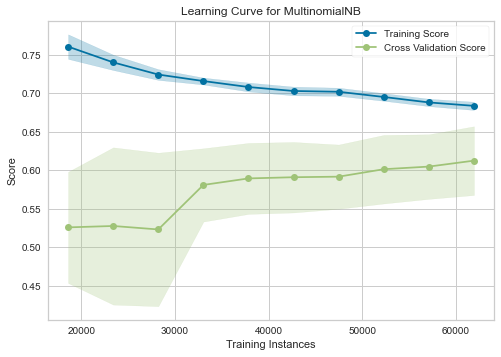

<AxesSubplot:title={'center':'Learning Curve for MultinomialNB'}, xlabel='Training Instances', ylabel='Score'>

In [85]:
import numpy as np

from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

from yellowbrick.datasets import load_game
from yellowbrick.model_selection import LearningCurve

# Load a classification dataset
X, y = load_game()

# Encode the categorical data
X = OneHotEncoder().fit_transform(X)
y = LabelEncoder().fit_transform(y)

# Create the learning curve visualizer
cv = StratifiedKFold(n_splits=12)
sizes = np.linspace(0.3, 1.0, 10)

# Instantiate the classification model and visualizer
model = MultinomialNB()
visualizer = LearningCurve(
    model, cv=cv, scoring='f1_weighted', train_sizes=sizes, n_jobs=4
)

visualizer.fit(X, y)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure

In [78]:
# make the prediction using the resulting model
preds_class = tuned_model.predict(data, prediction_type='Class')
preds_raw_vals = tuned_model.predict(data, prediction_type='RawFormulaVal')
preds_proba = tuned_model.predict(data, prediction_type='Probability')

# Eller preds_proba = cb_model.predict_proba(data)
print("class = ", preds_class[0:10])
print("proba = ", preds_proba[0:10])
print("proba = ", preds_raw_vals[0:10])

class =  ['M' 'R' 'R' 'R' 'R' 'R' 'R' 'M' 'R' 'R']
proba =  [[0.57273692 0.42726308]
 [0.27742023 0.72257977]
 [0.40350886 0.59649114]
 [0.35920385 0.64079615]
 [0.1485798  0.8514202 ]
 [0.11173796 0.88826204]
 [0.22492376 0.77507624]
 [0.59436353 0.40563647]
 [0.20119989 0.79880011]
 [0.18613874 0.81386126]]
proba =  [-0.29302655  0.95729438  0.39086594  0.57882132  1.74578357  2.07311027
  1.2371999  -0.38203376  1.37881183  1.47529762]


In [79]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_true = y, y_pred = preds_class)


array([[106,   5],
       [  8,  89]], dtype=int64)

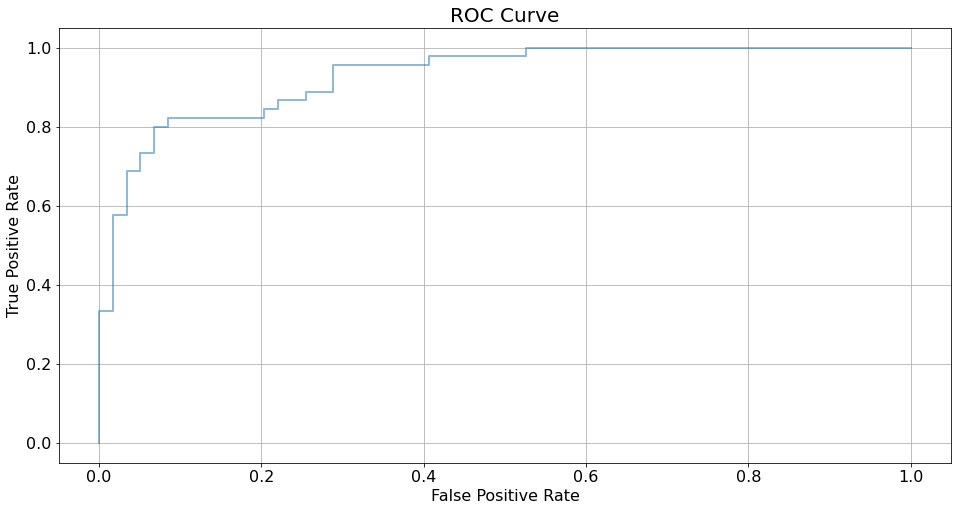

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.         0.02222222 0.04444444 0.06666667 0.08888889 0.11111111
 0.13333333 0.15555556 0.17777778 0.2       ]
[1.         0.93246468 0.92199831 0.89710578 0.87207614 0.86507075
 0.85962767 0.85901611 0.8459742  0.82716534]


In [80]:
# RoC Curve
from catboost.utils import get_roc_curve

catboost_pool = Pool(test_X, test_y)

(fpr, tpr, thresholds) = get_roc_curve(tuned_model, catboost_pool, plot=True)
print(fpr[0:10])
print(tpr[0:10])
print(thresholds[0:10])

#get_roc_curve(tuned_model, catboost_pool, plot=True)

In [58]:
#catboost_auc = eval_metric(toy_example['class'], toy_example['prediction'], 'AUC')[0]
#from catboost import eval_metrics
metrics = ['AUC']
catboost_pool = Pool(test_X, test_y)
catboost_auc = tuned_model.eval_metrics(catboost_pool,
             metrics,
             ntree_start=0,
             ntree_end=0,
             eval_period=1,
             thread_count=-1)

catboost_auc

{'AUC': [0.6491525423728813,
  0.7374764595103578,
  0.7595103578154425,
  0.7713747645951036,
  0.7734463276836159,
  0.8064030131826743,
  0.8369114877589454,
  0.8338983050847457,
  0.8546139359698681,
  0.8572504708097928,
  0.8572504708097928,
  0.8610169491525423,
  0.8625235404896422,
  0.8512241054613936,
  0.8617702448210922,
  0.864406779661017,
  0.8572504708097928,
  0.871939736346516,
  0.888135593220339,
  0.8787193973634652,
  0.8866290018832392,
  0.8952919020715631,
  0.8941619585687383,
  0.887758945386064,
  0.8903954802259887,
  0.8934086629001883,
  0.9047080979284369,
  0.9065913370998117,
  0.9107344632768362,
  0.9077212806026366,
  0.9073446327683616,
  0.9069679849340866,
  0.9156308851224105,
  0.9190207156308852,
  0.9261770244821093,
  0.9295668549905838,
  0.9340866290018832,
  0.9322033898305084,
  0.9258003766478343,
  0.9273069679849341,
  0.9205273069679849,
  0.9182674199623352,
  0.9220338983050848,
  0.9163841807909605,
  0.9163841807909605,
  0.916

In [29]:
# Save Model

In [34]:
tuned_model.save_model(fname="tuned_model",
                       format="cbm",
                       export_parameters=None,
                       #pool=None
                      )



In [35]:
# Save model as json
tuned_model.save_model(
    "model.json",
    format="json",
    # pool=pool  # this parameter is required only for models with categorical features.
)

In [36]:
# Load
import json
model = json.load(open("model.json", "r"))
model.keys()

dict_keys(['features_info', 'model_info', 'oblivious_trees', 'scale_and_bias'])

In [37]:
print(model['model_info']['catboost_version_info'])

Git info:
    Commit: e94bcd3987d868ce0832af0a6aa61dc1b123ed45
    Branch: heads/master
    Author: somov <somov@yandex-team.ru>
    Summary: Fix clang-cl build: contrib/libs/lzmasdk
    git-svn info:
    Last Changed Rev: 7251233

Other info:
    Build by: PLATFORM-W10$
    Top src dir: C:\Program Files (x86)\Go Agent\pipelines\BuildMaster\catboost.git
    Top build dir: C:\Users\zomb-ml-platform-msk\.ya\build
    Hostname: platform-w10
    Host information: 
        Microsoft Windows [Version 10.0.17134.1667]

    


In [38]:
model['features_info'].keys()

dict_keys(['float_features'])

In [39]:
model['features_info']['float_features'][0]

{'borders': [0.0052999998442828655,
  0.009050000458955765,
  0.012749999761581421,
  0.04084999859333038,
  0.042900003492832184,
  0.10854999721050262],
 'feature_index': 0,
 'flat_feature_index': 0,
 'has_nans': False,
 'nan_value_treatment': 'AsIs'}

In [40]:

def dump_json(item):
    print(json.dumps(item, indent=2))

dump_json(model['oblivious_trees'][0])  # first_tree

{
  "leaf_values": [
    0.05745703763877551,
    0.19299631041764287,
    -0.030025542612934893,
    0.019527848974632226,
    0.019527848974632226,
    -0.002808464337917916,
    0,
    0,
    -0.006103316708903552,
    0.06211021830953289,
    -0.10187758078403128,
    -0.055473038596464436,
    -0.09273474460102127,
    -0.045450835803532166,
    0,
    0,
    0,
    0.09729657445188579,
    0,
    0,
    -0.07726183711735377,
    -0.0672446855714295,
    0,
    -0.055473038596464436,
    -0.07726183711735377,
    -0.04683029633336233,
    0,
    -0.07726183711735377,
    -0.10187758078403128,
    -0.098715328593874,
    -0.12733725677963087,
    -0.055473038596464436
  ],
  "leaf_weights": [
    4.49561619758606,
    28.343217432498932,
    1,
    2.74780809879303,
    2.74780809879303,
    17.73904049396515,
    0,
    0,
    3.74780809879303,
    7.243424296379089,
    6.873904049396515,
    2,
    8.74780809879303,
    16.117328345775604,
    0,
    0,
    0,
    9.865136444568